# Data Description

This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allow viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. There is also a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.

This is real commercial data which has been anonymised.

# Context

This dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. 

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

# Data Science Problem Statement(s)

Through this dataset, I will use various machine learning methods for the following problems -  

1) Segmentation - How can customers be clustered based on their purchase habits?   
2) Customer Lifetime Value - How much will a customer bring in future revenue?  
3) Churn - Which customers are likely to remain or not remain with Olist?  
4) Recommendations - How can we increase user basket size by engaging users more with a recommendation system?  
5) Customer reviews - Can we predict customer review scores based on the various features?

The data is divided into multiple datasets for better organization. As such I will be working with different sub sets across the various project steps - depending on the objective. Please refer to the following data schema for clarity:
<img src="https://i.imgur.com/HRhd2Y0.png" />

# Why Segmentation?
Smart marketers understand the importance of “know thy customer.” Instead of simply focusing on generating more clicks, marketers must follow the paradigm shift from increased CTRs (Click-Through Rates) to retention, loyalty, and building customer relationships.

Instead of analyzing the entire customer base as a whole, it’s better to segment them into homogeneous groups, understand the traits of each group, and engage them with relevant campaigns rather than segmenting on just customer age or geography.

One of the most popular, easy-to-use, and effective segmentation methods to enable marketers to analyze customer behavior is RFM analysis.

#### What is RFM Analysis?

RFM stands for Recency, Frequency, and Monetary value, each corresponding to some key customer trait. These RFM metrics are important indicators of a customer’s behavior because frequency and monetary value affects a customer’s lifetime value, and recency affects retention, a measure of engagement.

RFM analysis helps marketers find answers to the following questions:

Who are your best customers?  
Which of your customers could contribute to your churn rate?  
Who has the potential to become valuable customers?  
Which of your customers can be retained?  
Which of your customers are most likely to respond to engagement campaigns?  

![title](../assets/RFM.png)

## Contents:
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Recency](#Recency)
- [Frequency](#Frequency)
- [Monetary](#Monetary)
- [Understanding Customer Segments](#Visualizing-customer-segments)
- [Model Prep](#Model-Prep)
- [Baseline Model](#Logistic-Regression)
- [Decision Tree](#Decision-Tree)
- [Random Forest](#Random-Forest)
- [Next Steps](#Next-Steps)

# Data Import and Cleaning

In [115]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set(style="ticks")
import gc
import itertools
from datetime import datetime
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 100)
np.random.seed(42)
import plotly
from datetime import datetime, timedelta
import plotly.offline as pyoff
import plotly.graph_objs as go
import plotly.express as px
#initiate visualization library for jupyter notebook 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
pyoff.init_notebook_mode(connected=True)
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, roc_curve, auc, precision_recall_fscore_support as score




In [2]:
#visualization functions - credit to Thiago Panini on kaggle
def format_spines(ax, right_border=True):
    
    ax.spines['bottom'].set_color('#666666')
    ax.spines['left'].set_color('#666666')
    ax.spines['top'].set_visible(False)
    if right_border:
        ax.spines['right'].set_color('#FFFFFF')
    else:
        ax.spines['right'].set_color('#FFFFFF')
    ax.patch.set_facecolor('#FFFFFF')
    

def count_plot(feature, df, colors='Blues_d', hue=False, ax=None, title=''):
    
    # Preparing variables
    ncount = len(df)
    if hue != False:
        ax = sns.countplot(x=feature, data=df, palette=colors, hue=hue, ax=ax)
    else:
        ax = sns.countplot(x=feature, data=df, palette=colors, ax=ax)
        
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
                ha='center', va='bottom') # set the alignment of the text
    
    # Final configuration
    if not hue:
        ax.set_title(df[feature].describe().name + ' Analysis', size=13, pad=15)
    else:
        ax.set_title(df[feature].describe().name + ' Analysis by ' + hue, size=13, pad=15)  
    if title != '':
        ax.set_title(title)       
    plt.tight_layout()
    
    
def bar_plot(x, y, df, colors='Blues_d', hue=False, ax=None, value=False, title=''):
    
    # Preparing variables
    try:
        ncount = sum(df[y])
    except:
        ncount = sum(df[x])
    #fig, ax = plt.subplots()
    if hue != False:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, hue=hue, ax=ax, ci=None)
    else:
        ax = sns.barplot(x=x, y=y, data=df, palette=colors, ax=ax, ci=None)

    # Setting borders
    format_spines(ax)

    # Setting percentage
    for p in ax.patches:
        xp=p.get_bbox().get_points()[:,0]
        yp=p.get_bbox().get_points()[1,1]
        if value:
            ax.annotate('{:.2f}k'.format(yp/1000), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
        else:
            ax.annotate('{:.1f}%'.format(100.*yp/ncount), (xp.mean(), yp), 
                    ha='center', va='bottom') # set the alignment of the text
    if not hue:
        ax.set_title(df[x].describe().name + ' Analysis', size=12, pad=15)
    else:
        ax.set_title(df[x].describe().name + ' Analysis by ' + hue, size=12, pad=15)
    if title != '':
        ax.set_title(title)  
    plt.tight_layout()

In [38]:
# load the data
customer = pd.read_csv('../datasets/olist/olist_customers_dataset.csv')
order = pd.read_csv('../datasets/olist/olist_orders_dataset.csv')
item = pd.read_csv('../datasets/olist/olist_order_items_dataset.csv')
payment = pd.read_csv('../datasets/olist/olist_order_payments_dataset.csv')
Olist_df = pd.read_csv('../datasets/Olist_final_clean.csv')

In [4]:
# creating custom dataframe (using only customer, order, item and payment DFs)
df1 = payment.merge(item, on='order_id')
df2 = df1.merge(order, on='order_id')
df = df2.merge(customer, on='customer_id')
print(df.shape)

(117601, 22)


In [5]:
# converting date columns to datetime
date_columns = ['shipping_limit_date', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')

In [6]:
# cleaning up name columns
df['customer_city'] = df['customer_city'].str.title()
df['payment_type'] = df['payment_type'].str.replace('_', ' ').str.title()
# engineering new/essential columns
df['delivery_against_estimated'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days
df['order_purchase_year'] = df.order_purchase_timestamp.apply(lambda x: x.year)
df['order_purchase_month'] = df.order_purchase_timestamp.apply(lambda x: x.month)
df['order_purchase_dayofweek'] = df.order_purchase_timestamp.apply(lambda x: x.dayofweek)
df['order_purchase_hour'] = df.order_purchase_timestamp.apply(lambda x: x.hour)
df['order_purchase_day'] = df['order_purchase_dayofweek'].map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
df['order_purchase_mon'] = df.order_purchase_timestamp.apply(lambda x: x.month).map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
# Changing the month attribute for correct ordenation
df['month_year'] = df['order_purchase_month'].astype(str).apply(lambda x: '0' + x if len(x) == 1 else x)
df['month_year'] = df['order_purchase_year'].astype(str) + '-' + df['month_year'].astype(str)
#creating year month column
df['month_y'] = df['order_purchase_timestamp'].map(lambda date: 100*date.year + date.month)

In [7]:
# displaying missing value counts and corresponding percentage against total observations
missing_values = df.isnull().sum().sort_values(ascending = False)
percentage = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([missing_values, percentage], axis=1, keys=['Values', 'Percentage']).transpose()

order_delivered_customer_date  delivery_against_estimated  \
Values                        2567.000000                 2567.000000   
Percentage                       2.182805                    2.182805   

            order_delivered_carrier_date  order_approved_at  month_year  \
Values                       1245.000000          15.000000         0.0   
Percentage                      1.058664           0.012755         0.0   

            order_purchase_mon  order_purchase_day  order_purchase_hour  \
Values                     0.0                 0.0                  0.0   
Percentage                 0.0                 0.0                  0.0   

            order_purchase_dayofweek  order_purchase_month  \
Values                           0.0                   0.0   
Percentage                       0.0                   0.0   

            order_purchase_year  customer_state  customer_city  \
Values                      0.0             0.0            0.0   
Percentage                  0.0             0.0            0.0   

            customer_zip_code_prefix  customer_unique_id  \
Values                           0.0                 0.0   
Percentage                       0.0                 0.0   

            order_estimated_delivery_date  order_id  payment_sequential  \
Values                                0.0       0.0                 0.0   
Percentage                            0.0       0.0                 0.0   

            order_purchase_timestamp  order_status  customer_id  \
Values                           0.0           0.0          0.0   
Percentage                       0.0           0.0          0.0   

            freight_value  price  shipping_limit_date  seller_id  product_id  \
Values                0.0    0.0                  0.0        0.0         0.0   
Percentage            0.0    0.0                  0.0        0.0         0.0   

            order_item_id  payment_value  payment_installments  payment_type  \
Values                0.0            0.0                   0.0           0.0   
Percentage            0.0            0.0                   0.0           0.0   

            month_y  
Values          0.0  
Percentage      0.0

In [8]:
# dropping missing values
df.dropna(inplace=True)
df.isnull().values.any()

False

In [9]:
# displaying dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115018 entries, 0 to 117600
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115018 non-null  object        
 1   payment_sequential             115018 non-null  int64         
 2   payment_type                   115018 non-null  object        
 3   payment_installments           115018 non-null  int64         
 4   payment_value                  115018 non-null  float64       
 5   order_item_id                  115018 non-null  int64         
 6   product_id                     115018 non-null  object        
 7   seller_id                      115018 non-null  object        
 8   shipping_limit_date            115018 non-null  datetime64[ns]
 9   price                          115018 non-null  float64       
 10  freight_value                  115018 non-null  float64       
 11  

In [10]:
# excluding incomplete 2012 data 
df = df.query("month_year != '2016-12' and month_year != '2016-10'")

# Recency

In [11]:
#creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

#gets the max purchase date for each customer and create a dataframe with it
df_max_purchase = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_max_purchase.columns = ['customer_unique_id', 'MaxPurchaseDate']

#we take our observation point as the max purchase date in our dataset
df_max_purchase['Recency'] = (df_max_purchase['MaxPurchaseDate'].max() - df_max_purchase['MaxPurchaseDate']).dt.days

#merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_max_purchase[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()

customer_unique_id  Recency
0  708ab75d2a007f0564aedd11139c7708      125
1  a8b9d3a27068454b1c98cc67d4e31e6f       64
2  6f70c0b2f7552832ba46eb57b1c5651e      260
3  87695ed086ebd36f20404c82d20fca87      266
4  4291db0da71914754618cd789aebcd56       28

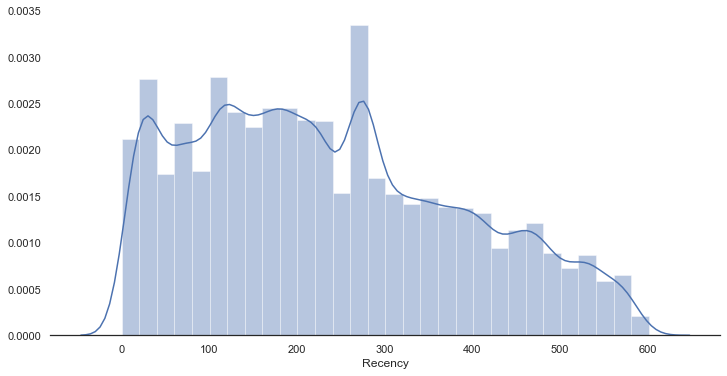

In [12]:
# plotting the distribution of the continous feature set
sns.set( color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

To validate the number of clusters, the Elbow Method will be used.  

This method estimates the optimal value of K produced. While iterating through increasing K values, average distortion decreases and vice a versa. The “elbow” calculates the point where distortion declines, or in other words if the plot looks like an arm, the elbow is where the forearm begins.

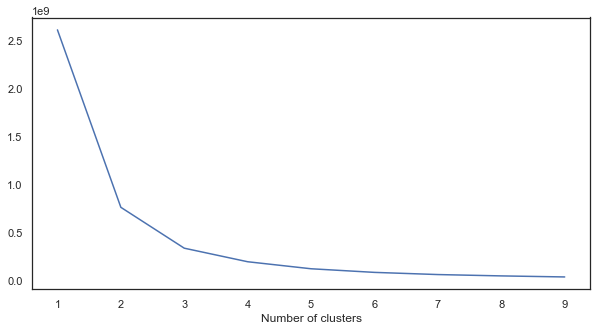

In [13]:
sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.show()

In [14]:
#building 5 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Recency']])
df_user['RecencyCluster'] = kmeans.predict(df_user[['Recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('RecencyCluster', 'Recency',df_user,False)

In [15]:
#displaying the details of each cluster
df_user.groupby('RecencyCluster')['Recency'].describe()

count        mean        std    min    25%    50%    75%  \
RecencyCluster                                                               
0               14624.0  503.084587  42.798837  439.0  466.0  496.0  537.0   
1               18609.0  373.900425  34.084795  317.0  344.0  373.0  403.0   
2               27424.0  258.589155  31.146748  205.0  230.0  264.0  280.0   
3               29978.0  150.630396  30.874496   99.0  123.0  150.0  178.0   
4               24046.0   47.217791  27.082977    0.0   23.0   43.0   71.0   

                  max  
RecencyCluster         
0               601.0  
1               438.0  
2               316.0  
3               204.0  
4                98.0

# Frequency

In [16]:
#get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

#add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

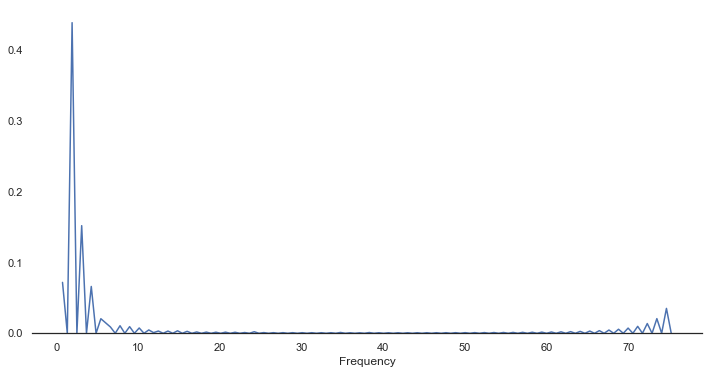

In [17]:
# plotting the distribution of the continous feature set
sns.set(style = 'white', color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [18]:
#k-means
kmeans = KMeans(n_clusters=5)
kmeans.fit(df_user[['Frequency']])
df_user['FrequencyCluster'] = kmeans.predict(df_user[['Frequency']])

#order the frequency cluster
df_user = order_cluster('FrequencyCluster', 'Frequency',df_user,True)

#see details of each cluster
df_user.groupby('FrequencyCluster')['Frequency'].describe()

count       mean       std   min   25%   50%   75%   max
FrequencyCluster                                                            
0                 99875.0   1.207900  0.405807   1.0   1.0   1.0   1.0   2.0
1                 12870.0   4.039005  1.186489   3.0   3.0   4.0   5.0   7.0
2                  1464.0  10.831967  2.252463   8.0   9.0  11.0  12.0  16.0
3                   397.0  24.536524  6.099081  18.0  20.0  22.0  24.0  38.0
4                    75.0  75.000000  0.000000  75.0  75.0  75.0  75.0  75.0

# Monetary

In [19]:
#calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

#merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

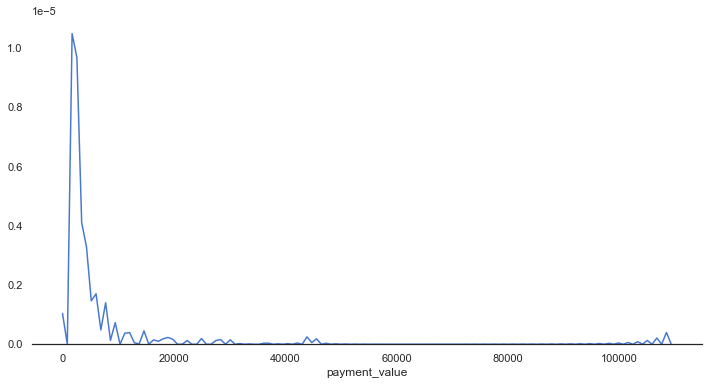

In [20]:
# plotting the distribution of the continous feature set
sns.set(style = 'white', palette='muted', color_codes=True)
fig, ax = plt.subplots(figsize=(12, 6))
sns.despine(left=True)
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

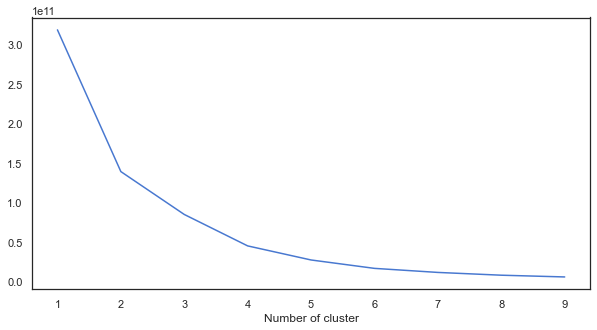

In [21]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [22]:
#apply clustering
kmeans = KMeans(n_clusters=6)
kmeans.fit(df_user[['payment_value']])
df_user['RevenueCluster'] = kmeans.predict(df_user[['payment_value']])


#order the cluster numbers
df_user = order_cluster('RevenueCluster', 'payment_value',df_user,True)

#show details of the dataframe
df_user.groupby('RevenueCluster')['payment_value'].describe()

count           mean          std        min        25%  \
RevenueCluster                                                               
0               108108.0     192.070624   190.070330       9.59      67.50   
1                 5592.0    1870.895504   816.778862    1026.78    1247.52   
2                  743.0    7000.283419  2137.860492    4447.80    5289.12   
3                  184.0   20278.110435  5207.417793   14196.28   16313.60   
4                   46.0   43587.292174  2837.177072   36489.24   44048.00   
5                    8.0  109312.640000     0.000000  109312.64  109312.64   

                      50%        75%        max  
RevenueCluster                                   
0                  124.13     232.97    1026.48  
1                 1592.64    2211.12    4415.96  
2                 6317.22    7971.88   12490.88  
3                19174.38   25051.89   30186.00  
4                44048.00   45256.00   45256.00  
5               109312.64  109312.64  109312.64

In [23]:
#renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'RecencyCluster', 'Frequency', 'FrequencyCluster', 'Monetary', 'RevenueCluster']
#calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['RecencyCluster'] + df_user['FrequencyCluster'] + df_user['RevenueCluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

Recency  Frequency      Monetary
OverallScore                                     
0             502.486153   1.207470    166.043273
1             384.014916   1.374942    198.962138
2             271.018133   1.468459    221.534546
3             167.438145   1.585506    255.314096
4              69.003531   1.702820    310.602300
5             103.659494   6.017214   1235.705094
6              90.805680   6.739910   3053.829791
7             114.172260  11.863535   6191.532438
8             156.974843  12.257862  24128.473333
10             96.454545  22.181818  35259.341818

In [24]:
df_user.describe()

Recency  RecencyCluster      Frequency  FrequencyCluster  \
count  114681.000000   114681.000000  114681.000000     114681.000000   
mean      235.937671        2.263453       1.777496          0.150757   
std       150.795167        1.305015       2.774387          0.426827   
min         0.000000        0.000000       1.000000          0.000000   
25%       113.000000        1.000000       1.000000          0.000000   
50%       217.000000        2.000000       1.000000          0.000000   
75%       344.000000        3.000000       2.000000          0.000000   
max       601.000000        4.000000      75.000000          4.000000   

            Monetary  RevenueCluster   OverallScore  
count  114681.000000   114681.000000  114681.000000  
mean      375.287259        0.068486       2.482695  
std      1667.357251        0.304285       1.452395  
min         9.590000        0.000000       0.000000  
25%        70.040000        0.000000       1.000000  
50%       133.490000        0.000000       3.000000  
75%       276.720000        0.000000       4.000000  
max    109312.640000        5.000000      10.000000

There seem to be some outliers in Frequency and Monetary. I will remove them before proceeding.

In [25]:
#removing outliers for frequency
df_user = df_user[df_user['Frequency']<70]

In [26]:
df_user['Monetary'].value_counts().sort_values()

135.01       1
336.61       1
1347.96      1
745.30       1
294.37       1
          ... 
310.28     113
116.94     126
73.34      154
35.00      172
77.57      240
Name: Monetary, Length: 30391, dtype: int64

In [27]:
#removing outliers for monetary
df_user = df_user[df_user['Monetary']<50_000]

In [28]:
df_user

customer_unique_id  Recency  RecencyCluster  Frequency  \
0       708ab75d2a007f0564aedd11139c7708      125               3          1   
1       6e3c218d5f0434ddc4af3d6a60767bbf      114               3          2   
2       6e3c218d5f0434ddc4af3d6a60767bbf      114               3          2   
3       0ae522661311f598df20272643d39ce6      160               3          1   
4       d386a136dc889cf681443061874caad8      113               3          1   
...                                  ...      ...             ...        ...   
114668  698e1cf81d01a3d389d96145f7fa6df8      371               1         20   
114669  698e1cf81d01a3d389d96145f7fa6df8      371               1         20   
114670  698e1cf81d01a3d389d96145f7fa6df8      371               1         20   
114671  698e1cf81d01a3d389d96145f7fa6df8      371               1         20   
114672  698e1cf81d01a3d389d96145f7fa6df8      371               1         20   

        FrequencyCluster  Monetary  RevenueCluster  OverallScore  
0                      0     99.33               0             3  
1                      0    192.24               0             3  
2                      0    192.24               0             3  
3                      0    157.45               0             3  
4                      0    136.71               0             3  
...                  ...       ...             ...           ...  
114668                 3  45256.00               4             8  
114669                 3  45256.00               4             8  
114670                 3  45256.00               4             8  
114671                 3  45256.00               4             8  
114672                 3  45256.00               4             8  

[114598 rows x 8 columns]

# Visualizing customer segments

In [29]:
#assigning value labels to our segments
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>6,'Segment'] = 'High-Value' 

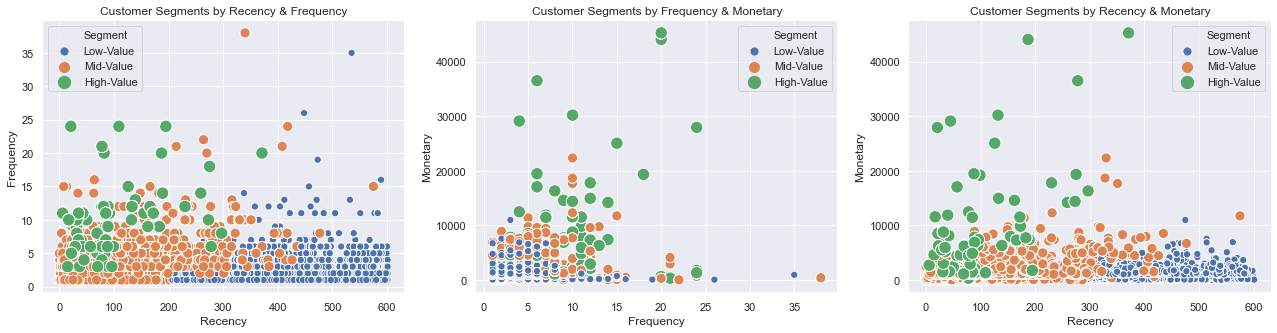

In [30]:
# plotting the distribution of the continous feature set
sns.set(color_codes=True)
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()

In [31]:
# visualize the customer segments via plotly
fig = px.scatter_3d(df_user, x='Recency', y='Monetary', z='Frequency', color='Segment', size_max=5)
fig.show()

In [32]:
# the mean value for each cluster
cluster_avg = df_user.groupby('Segment').mean()
cluster_avg.drop(['RecencyCluster','FrequencyCluster', 'RevenueCluster'], axis = 1)

Recency  Frequency      Monetary  OverallScore
Segment                                                      
High-Value  120.831776  12.716511  11341.047009      7.440810
Low-Value   292.965503   1.450648    220.248271      1.841531
Mid-Value    73.581663   2.291888    552.304958      4.215372

In [33]:
Olist_df

order_id order_item_id  \
0       00010242fe8c5a6d1ba2dd792cb16214             1   
1       130898c0987d1801452a8ed92a670612             1   
2       532ed5e14e24ae1f0d735b91524b98b9             1   
3       6f8c31653edb8c83e1a739408b5ff750             1   
4       7d19f4ef4d04461989632411b7e588b9             1   
...                                  ...           ...   
118313  fdaf98feac227eb978d8f33f36e0231d             1   
118314  fe68b52db13993f58175fa589125d345             1   
118315  fefacc66af859508bf1a7934eab1e97f             1   
118316  ff701a7c869ad21de22a6994237c8a00             1   
118317  ff701a7c869ad21de22a6994237c8a00             2   

                              product_id                         seller_id  \
0       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
2       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
3       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
4       4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
...                                  ...                               ...   
118313  f739e9151702508b18f796c53005e5e9  d1aa1ec0839dcab73a6161130eb1f94a   
118314  f4135cbdece8245560f7be179533797a  3fefda3299e6dfaea3466ef346a3571a   
118315  69c590f7ffc7bf8db97190b6cb6ed62e  80ceebb4ee9b31afb6c6a916a574a1e2   
118316  5ff4076c0f01eeba4f728c9e3fa2653c  3e35a8bb43569389d3cebef0ce820f69   
118317  5ff4076c0f01eeba4f728c9e3fa2653c  3e35a8bb43569389d3cebef0ce820f69   

        shipping_limit_date   price freight_value payment_sequential  \
0       2017-09-19 09:45:35    58.9         13.29                  1   
1       2017-07-05 02:44:11    55.9         17.96                  1   
2       2018-05-23 10:56:25    64.9         18.33                  1   
3       2017-08-07 18:55:08    58.9         16.17                  1   
4       2017-08-16 22:05:11    58.9         13.29                  1   
...                     ...     ...           ...                ...   
118313  2017-04-27 05:10:28   119.9         16.14                  1   
118314  2017-08-17 02:55:27   209.0         16.21                  1   
118315  2018-08-02 04:05:13  6729.0        193.21                  1   
118316  2018-04-18 20:10:33    27.9         14.44                  1   
118317  2018-04-18 20:10:33    27.9         14.44                  1   

       payment_type payment_installments payment_value product_category_name  \
0       Credit Card                    2         72.19            Cool Stuff   
1            Boleto                    1         73.86            Cool Stuff   
2       Credit Card                    2         83.23            Cool Stuff   
3       Credit Card                    3         75.07            Cool Stuff   
4       Credit Card                    4         72.19            Cool Stuff   
...             ...                  ...           ...                   ...   
118313       Boleto                    1        136.04       Furniture Decor   
118314       Boleto                    1        225.21           Electronics   
118315       Boleto                    1       6922.21             Computers   
118316  Credit Card                    1         84.68                Drinks   
118317  Credit Card                    1         84.68                Drinks   

       product_name_lenght product_description_lenght  product_photos_qty  \
0                     58.0                      598.0                 4.0   
1                     58.0                      598.0                 4.0   
2                     58.0                      598.0                 4.0   
3                     58.0                      598.0                 4.0   
4                     58.0                      598.0                 4.0   
...                    ...                        ...                 ...   
118313                44.0       

In [40]:
# Merge RFM to original dataframe
olist_class = Olist_df.merge(df_user, how='inner', on='customer_unique_id').copy()


In [41]:
olist_class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200722 entries, 0 to 200721
Data columns (total 64 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       200722 non-null  object 
 1   order_item_id                  200722 non-null  object 
 2   product_id                     200722 non-null  object 
 3   seller_id                      200722 non-null  object 
 4   shipping_limit_date            200722 non-null  object 
 5   price                          200722 non-null  object 
 6   freight_value                  200722 non-null  object 
 7   payment_sequential             200722 non-null  object 
 8   payment_type                   200722 non-null  object 
 9   payment_installments           200722 non-null  object 
 10  payment_value                  200722 non-null  object 
 11  product_category_name          197788 non-null  object 
 12  product_name_lenght           

In [42]:
#checkpoint save CSV
olist_class.to_csv('../datasets/Olist_final_with_segments.csv', index = False)

# Building a profile of our high/mid/low value customers

In [44]:
plot_list = ['customer_city', 'payment_type', 'product_category_name','review_score','order_purchase_day', 'order_purchase_time_day']

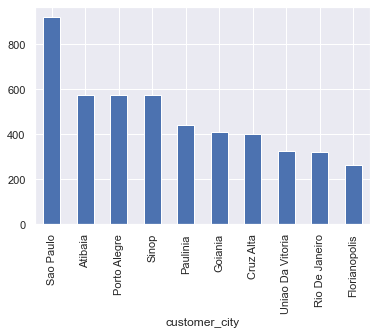

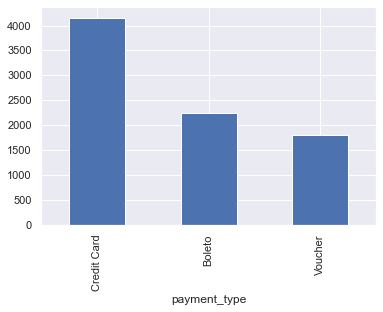

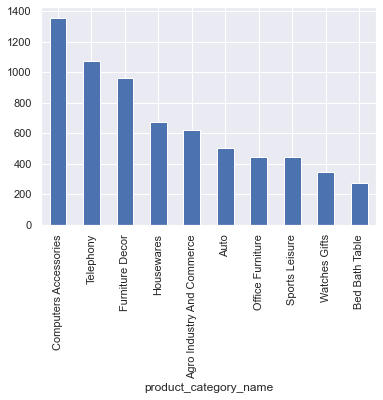

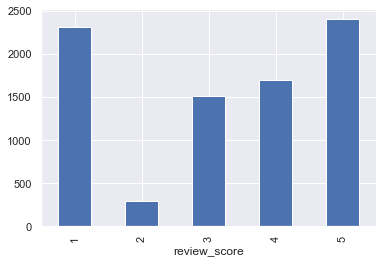

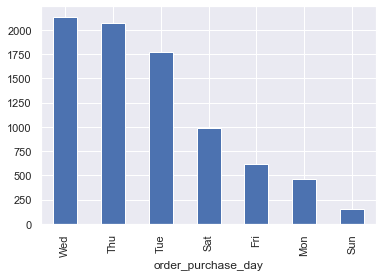

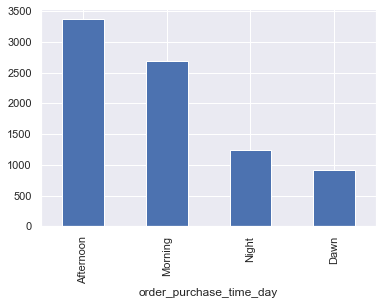

In [63]:
#High value customers

for i in plot_list:
    plt.figure()
    olist_class.groupby('Segment')[i].value_counts()['High-Value'][:10].plot(kind = 'bar');


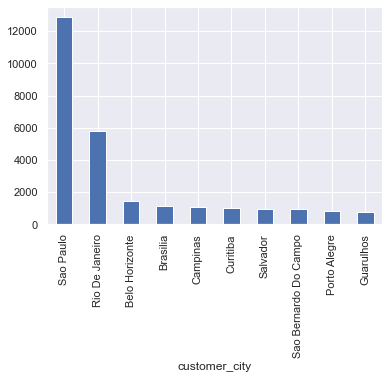

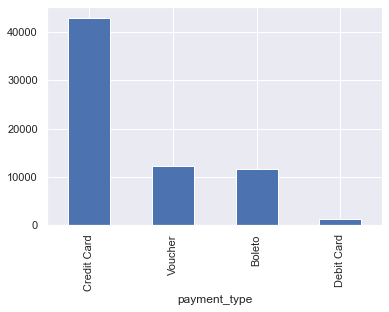

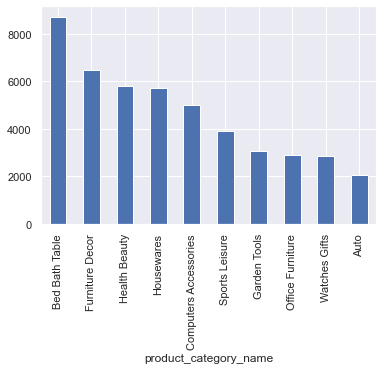

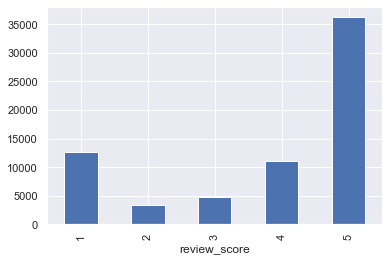

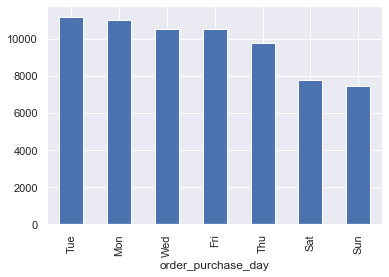

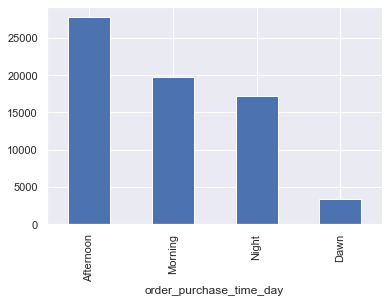

In [64]:
#Mid value customers

for i in plot_list:
    plt.figure()
    olist_class.groupby('Segment')[i].value_counts()['Mid-Value'][:10].plot(kind = 'bar');



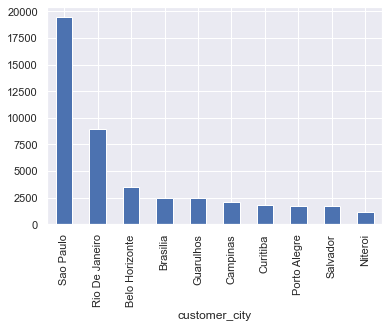

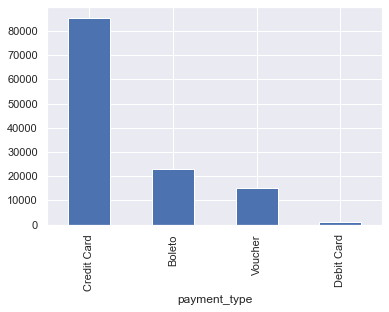

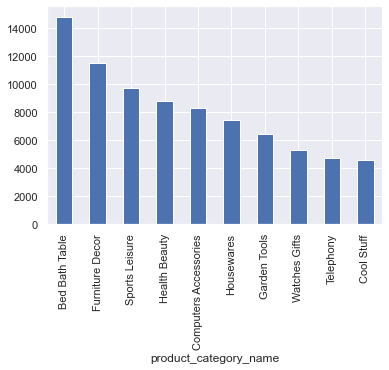

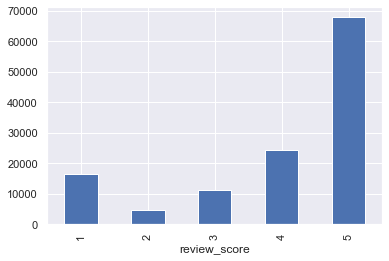

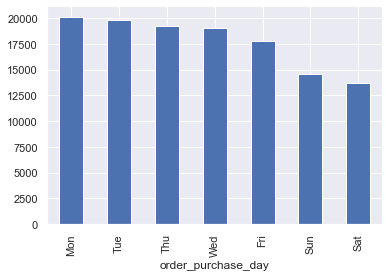

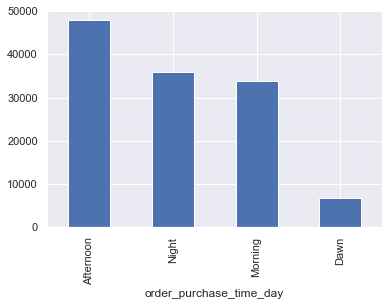

In [65]:
#Low value customers

for i in plot_list:
    plt.figure()
    olist_class.groupby('Segment')[i].value_counts()['Low-Value'][:10].plot(kind = 'bar');



# Model Prep

In [73]:
# Predictor Columns
all_columns = [
    'customer_state'
    , 'order_status'
    , 'price'
    , 'freight_value'
    , 'product_category_name'
    , 'product_photos_qty'
    , 'product_weight_g'
    , 'product_length_cm'
    , 'product_height_cm'
    , 'product_width_cm'
    , 'payment_sequential'
    , 'payment_type'
    , 'payment_installments'
    , 'payment_value'
    , 'review_score'
    , 'Segment'
    , 'order_purchase_time_day'
    , 'order_purchase_day'
]

In [74]:
# Copy only Predictor and Target Columns
dummy_seek = olist_class[all_columns].copy()
dummy_seek.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200722 entries, 0 to 200721
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   customer_state           200722 non-null  object 
 1   order_status             200722 non-null  object 
 2   price                    200722 non-null  object 
 3   freight_value            200722 non-null  object 
 4   product_category_name    197788 non-null  object 
 5   product_photos_qty       197788 non-null  float64
 6   product_weight_g         200681 non-null  float64
 7   product_length_cm        200681 non-null  float64
 8   product_height_cm        200681 non-null  float64
 9   product_width_cm         200681 non-null  float64
 10  payment_sequential       200722 non-null  object 
 11  payment_type             200722 non-null  object 
 12  payment_installments     200722 non-null  object 
 13  payment_value            200722 non-null  object 
 14  revi

In [75]:
# Create Dummy Variables for Customer State (as opposed to city - too many columns and likely to overfit)
dummy_seek = pd.get_dummies(dummy_seek, columns=['customer_state'], prefix=['customer_state'], drop_first=True)
dummy_seek.head()

order_status price freight_value product_category_name  product_photos_qty  \
0    delivered  58.9         13.29            Cool Stuff                 4.0   
1    delivered  55.9         17.96            Cool Stuff                 4.0   
2    delivered  64.9         18.33            Cool Stuff                 4.0   
3    delivered  58.9         16.17            Cool Stuff                 4.0   
4    delivered  58.9         13.29            Cool Stuff                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1             650.0               28.0                9.0              14.0   
2             650.0               28.0                9.0              14.0   
3             650.0               28.0                9.0              14.0   
4             650.0               28.0                9.0              14.0   

  payment_sequential payment_type payment_installments payment_value  \
0                  1  Credit Card                    2         72.19   
1                  1       Boleto                    1         73.86   
2                  1  Credit Card                    2         83.23   
3                  1  Credit Card                    3         75.07   
4                  1  Credit Card                    4         72.19   

   review_score    Segment order_purchase_time_day order_purchase_day  \
0             5  Low-Value                 Morning                Wed   
1             5  Low-Value                 Morning                Wed   
2             4  Low-Value                 Morning                Fri   
3             5  Low-Value               Afternoon                Tue   
4             5  Low-Value                   Night                Thu   

   customer_state_AL  customer_state_AM  customer_state_AP  customer_state_BA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_CE  customer_state_DF  customer_state_ES  customer_state_GO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MA  customer_state_MG  customer_state_MS  customer_state_MT  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   

   customer_state_PA  customer_state_PB  customer_state_PE  customer_state_PI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PR  customer_state_RJ  customer_state_RN  customer_state_RO  \
0                  0                  1                  0                  0   
1                  0                  0                  0      

In [76]:
# Create Dummy Variables for Order Status
dummy_seek = pd.get_dummies(dummy_seek, columns=['order_status'], prefix=['order_status'], drop_first=True)
dummy_seek.head()

price freight_value product_category_name  product_photos_qty  \
0  58.9         13.29            Cool Stuff                 4.0   
1  55.9         17.96            Cool Stuff                 4.0   
2  64.9         18.33            Cool Stuff                 4.0   
3  58.9         16.17            Cool Stuff                 4.0   
4  58.9         13.29            Cool Stuff                 4.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  \
0             650.0               28.0                9.0              14.0   
1             650.0               28.0                9.0              14.0   
2             650.0               28.0                9.0              14.0   
3             650.0               28.0                9.0              14.0   
4             650.0               28.0                9.0              14.0   

  payment_sequential payment_type payment_installments payment_value  \
0                  1  Credit Card                    2         72.19   
1                  1       Boleto                    1         73.86   
2                  1  Credit Card                    2         83.23   
3                  1  Credit Card                    3         75.07   
4                  1  Credit Card                    4         72.19   

   review_score    Segment order_purchase_time_day order_purchase_day  \
0             5  Low-Value                 Morning                Wed   
1             5  Low-Value                 Morning                Wed   
2             4  Low-Value                 Morning                Fri   
3             5  Low-Value               Afternoon                Tue   
4             5  Low-Value                   Night                Thu   

   customer_state_AL  customer_state_AM  customer_state_AP  customer_state_BA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_CE  customer_state_DF  customer_state_ES  customer_state_GO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MA  customer_state_MG  customer_state_MS  customer_state_MT  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   

   customer_state_PA  customer_state_PB  customer_state_PE  customer_state_PI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PR  customer_state_RJ  customer_state_RN  customer_state_RO  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0   

In [77]:
# Create Dummy Variables for Product Category
dummy_seek = pd.get_dummies(dummy_seek, columns=['product_category_name'], prefix=['product_category_name'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_type payment_installments payment_value  review_score    Segment  \
0  Credit Card                    2         72.19             5  Low-Value   
1       Boleto                    1         73.86             5  Low-Value   
2  Credit Card                    2         83.23             4  Low-Value   
3  Credit Card                    3         75.07             5  Low-Value   
4  Credit Card                    4         72.19             5  Low-Value   

  order_purchase_time_day order_purchase_day  customer_state_AL  \
0                 Morning                Wed                  0   
1                 Morning                Wed                  0   
2                 Morning                Fri                  0   
3               Afternoon                Tue                  0   
4                   Night                Thu                  0   

   customer_state_AM  customer_state_AP  customer_state_BA  customer_state_CE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_DF  customer_state_ES  customer_state_GO  customer_state_MA  \
0                  0                  0                  0                  0   
1                  0                  0                  1                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MG  customer_state_MS  customer_state_MT  customer_state_PA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  1                  0                  0                  0   
3                  0                  0                  0                  0   
4                  1                  0                  0                  0   

   customer_state_PB  customer_state_PE  customer_state_PI  customer_state_PR  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  1   
4                  0                  0                  0                  0   

   customer_state_RJ  customer_state_RN  customer_state_RO  customer_state_RR  \
0                  1                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0  

In [78]:
# Create Dummy Variables for Payment Type
dummy_seek = pd.get_dummies(dummy_seek, columns=['payment_type'], prefix=['payment_type'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value  review_score    Segment  \
0                    2         72.19             5  Low-Value   
1                    1         73.86             5  Low-Value   
2                    2         83.23             4  Low-Value   
3                    3         75.07             5  Low-Value   
4                    4         72.19             5  Low-Value   

  order_purchase_time_day order_purchase_day  customer_state_AL  \
0                 Morning                Wed                  0   
1                 Morning                Wed                  0   
2                 Morning                Fri                  0   
3               Afternoon                Tue                  0   
4                   Night                Thu                  0   

   customer_state_AM  customer_state_AP  customer_state_BA  customer_state_CE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_DF  customer_state_ES  customer_state_GO  customer_state_MA  \
0                  0                  0                  0                  0   
1                  0                  0                  1                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MG  customer_state_MS  customer_state_MT  customer_state_PA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  1                  0                  0                  0   
3                  0                  0                  0                  0   
4                  1                  0                  0                  0   

   customer_state_PB  customer_state_PE  customer_state_PI  customer_state_PR  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  1   
4                  0                  0                  0                  0   

   customer_state_RJ  customer_state_RN  customer_state_RO  customer_state_RR  \
0                  1                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  

In [79]:
# Create Dummy Variables for Review score
dummy_seek = pd.get_dummies(dummy_seek, columns=['review_score'], prefix=['review_score'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value    Segment order_purchase_time_day  \
0                    2         72.19  Low-Value                 Morning   
1                    1         73.86  Low-Value                 Morning   
2                    2         83.23  Low-Value                 Morning   
3                    3         75.07  Low-Value               Afternoon   
4                    4         72.19  Low-Value                   Night   

  order_purchase_day  customer_state_AL  customer_state_AM  customer_state_AP  \
0                Wed                  0                  0                  0   
1                Wed                  0                  0                  0   
2                Fri                  0                  0                  0   
3                Tue                  0                  0                  0   
4                Thu                  0                  0                  0   

   customer_state_BA  customer_state_CE  customer_state_DF  customer_state_ES  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_GO  customer_state_MA  customer_state_MG  customer_state_MS  \
0                  0                  0                  0                  0   
1                  1                  0                  0                  0   
2                  0                  0                  1                  0   
3                  0                  0                  0                  0   
4                  0                  0                  1                  0   

   customer_state_MT  customer_state_PA  customer_state_PB  customer_state_PE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PI  customer_state_PR  customer_state_RJ  customer_state_RN  \
0                  0                  0                  1                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  1                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RO  customer_state_RR  customer_state_RS  customer_state_SC  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2            

In [80]:
# Create Dummy Variables for time of day
dummy_seek = pd.get_dummies(dummy_seek, columns=['order_purchase_time_day'], prefix=['order_purchase_time_day'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value    Segment order_purchase_day  \
0                    2         72.19  Low-Value                Wed   
1                    1         73.86  Low-Value                Wed   
2                    2         83.23  Low-Value                Fri   
3                    3         75.07  Low-Value                Tue   
4                    4         72.19  Low-Value                Thu   

   customer_state_AL  customer_state_AM  customer_state_AP  customer_state_BA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_CE  customer_state_DF  customer_state_ES  customer_state_GO  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  1   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MA  customer_state_MG  customer_state_MS  customer_state_MT  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  1                  0                  0   
3                  0                  0                  0                  0   
4                  0                  1                  0                  0   

   customer_state_PA  customer_state_PB  customer_state_PE  customer_state_PI  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_PR  customer_state_RJ  customer_state_RN  customer_state_RO  \
0                  0                  1                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  1                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RR  customer_state_RS  customer_state_SC  customer_state_SE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0    

In [81]:
# Create Dummy Variables for purchase day
dummy_seek = pd.get_dummies(dummy_seek, columns=['order_purchase_day'], prefix=['order_purchase_day'], drop_first=True)
dummy_seek.head()

price freight_value  product_photos_qty  product_weight_g  \
0  58.9         13.29                 4.0             650.0   
1  55.9         17.96                 4.0             650.0   
2  64.9         18.33                 4.0             650.0   
3  58.9         16.17                 4.0             650.0   
4  58.9         13.29                 4.0             650.0   

   product_length_cm  product_height_cm  product_width_cm payment_sequential  \
0               28.0                9.0              14.0                  1   
1               28.0                9.0              14.0                  1   
2               28.0                9.0              14.0                  1   
3               28.0                9.0              14.0                  1   
4               28.0                9.0              14.0                  1   

  payment_installments payment_value    Segment  customer_state_AL  \
0                    2         72.19  Low-Value                  0   
1                    1         73.86  Low-Value                  0   
2                    2         83.23  Low-Value                  0   
3                    3         75.07  Low-Value                  0   
4                    4         72.19  Low-Value                  0   

   customer_state_AM  customer_state_AP  customer_state_BA  customer_state_CE  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_DF  customer_state_ES  customer_state_GO  customer_state_MA  \
0                  0                  0                  0                  0   
1                  0                  0                  1                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_MG  customer_state_MS  customer_state_MT  customer_state_PA  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  1                  0                  0                  0   
3                  0                  0                  0                  0   
4                  1                  0                  0                  0   

   customer_state_PB  customer_state_PE  customer_state_PI  customer_state_PR  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  1   
4                  0                  0                  0                  0   

   customer_state_RJ  customer_state_RN  customer_state_RO  customer_state_RR  \
0                  1                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0                  0                  0   
3                  0                  0                  0                  0   
4                  0                  0                  0                  0   

   customer_state_RS  customer_state_SC  customer_state_SE  customer_state_SP  \
0                  0                  0                  0                  0   
1                  0                  0                  0                  0   
2                  0                  0    

In [82]:
# Check Columns
dummy_seek.columns

Index(['price', 'freight_value', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'payment_sequential', 'payment_installments', 'payment_value',
       ...
       'review_score_5', 'order_purchase_time_day_Dawn',
       'order_purchase_time_day_Morning', 'order_purchase_time_day_Night',
       'order_purchase_day_Mon', 'order_purchase_day_Sat',
       'order_purchase_day_Sun', 'order_purchase_day_Thu',
       'order_purchase_day_Tue', 'order_purchase_day_Wed'],
      dtype='object', length=129)

In [83]:
# Split into target and predictors
target_column = 'Segment'
predictor_columns = [s for s in dummy_seek.columns.tolist() if s != target_column]

In [84]:
dummy_seek.shape

(200722, 129)

In [85]:
dummy_seek.dropna(inplace = True)

In [86]:
dummy_seek.shape

(197787, 129)

In [87]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(dummy_seek[predictor_columns], dummy_seek[target_column], random_state = 42)

In [105]:
X_train.shape

(148340, 128)

In [106]:
y_train.shape

(148340,)

In [107]:
X_test.shape

(49447, 128)

In [108]:
y_test.shape

(49447,)

In [110]:
# Standardize Train and Test
ss = StandardScaler().fit(X_train)

X_trainstd = ss.transform(X_train)
X_teststd = ss.transform(X_test)

# Logistic Regression

In [112]:
logreg = LogisticRegression(solver = 'newton-cg')
logreg.fit(X_trainstd, y_train)

LogisticRegression(solver='newton-cg')

In [113]:
# decent baseline score of 71%
logreg.score(X_teststd, y_test)

0.7073634396424454

              precision    recall  f1-score   support

  High-Value       0.77      0.59      0.67      2039
   Low-Value       0.72      0.91      0.80     30723
   Mid-Value       0.65      0.35      0.46     16685

    accuracy                           0.71     49447
   macro avg       0.71      0.62      0.64     49447
weighted avg       0.70      0.71      0.68     49447



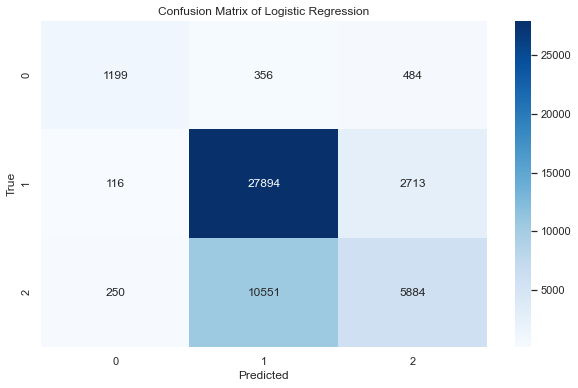

In [114]:
y_pred = logreg.predict(X_teststd)
    
print(classification_report(y_test, y_pred))

# confusion matrix - heat map plot
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix of Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

fig.savefig('logisticregression.png', bbox_inches='tight');

# Decision Tree

In [118]:
random_grid = {
    'n_estimators': [20, 40, 60, 80, 100]
    , 'max_features': ['auto', 'sqrt']
    , 'max_depth': [10, 55, 100, None]
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
dt = tree.DecisionTreeClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 25 different combinations, and use all available cores
dt_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
dt_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  5.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 55, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [20, 40, 60, 80, 100]},
                   random_state=42, verbose=2)

In [119]:
dt_random.best_estimator_, dt_random.best_score_

(RandomForestClassifier(max_depth=55, max_features='sqrt'), 0.9192598085479304)

In [120]:
# Fit Decision Tree Classfier

dt = tree.DecisionTreeClassifier(max_depth=55, max_features='sqrt', random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=55, max_features='sqrt', random_state=42)

In [122]:
# DT with a score of 88% 
score = dt.score(X_test, y_test)
score

0.8861811636701923

              precision    recall  f1-score   support

  High-Value       0.99      1.00      1.00      2039
   Low-Value       0.91      0.90      0.91     30723
   Mid-Value       0.82      0.84      0.83     16685

    accuracy                           0.89     49447
   macro avg       0.91      0.92      0.91     49447
weighted avg       0.89      0.89      0.89     49447



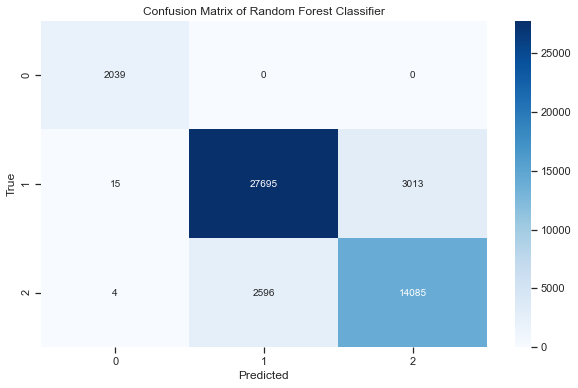

In [123]:
y_pred = dt.predict(X_test)
    
print(classification_report(y_test, y_pred))

# confusion matrix - heat map plot
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

fig.savefig('decisiontree.png', bbox_inches='tight');

In [124]:
dt.feature_importances_

array([1.03293242e-01, 1.29831467e-01, 2.65309104e-02, 7.58531504e-02,
       5.39867647e-02, 6.35334654e-02, 5.37483798e-02, 4.86177365e-03,
       3.27924727e-02, 1.36945758e-01, 2.83842203e-04, 3.50031165e-04,
       5.23370650e-05, 5.19807537e-03, 1.23027580e-03, 1.93531100e-03,
       2.28901490e-03, 1.85500782e-03, 8.21257960e-04, 5.38461009e-03,
       1.01830995e-03, 6.20047053e-03, 7.64387245e-04, 9.15678637e-04,
       2.59133153e-03, 7.43272006e-04, 4.23612960e-03, 6.57684512e-03,
       4.16430572e-04, 4.84259102e-04, 2.33462987e-05, 5.52716399e-03,
       5.22799254e-03, 3.11590262e-04, 1.00979804e-02, 5.88184092e-04,
       2.54585272e-04, 2.46414749e-05, 1.21062832e-04, 2.33196558e-04,
       5.03918560e-04, 4.11853840e-04, 1.28401258e-04, 6.41792099e-04,
       3.99788439e-03, 3.44976375e-03, 6.46507006e-03, 4.94951895e-04,
       1.95663549e-04, 2.29385687e-04, 1.96621626e-06, 1.15646006e-04,
       9.49071618e-05, 2.86787264e-04, 5.79476439e-03, 1.02851524e-03,
      

In [125]:
# Get feature importance from model and map them with feature names
feature_importances = pd.DataFrame(
    clf.feature_importances_
    , index = X_train.columns
    , columns=['importance']
).sort_values(by='importance', ascending=False)

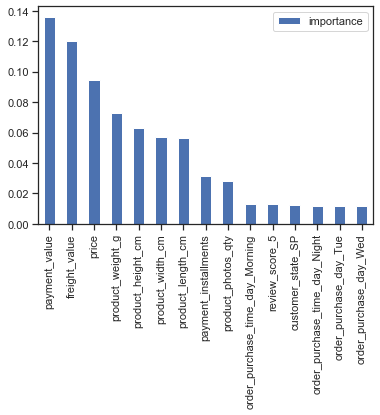

In [126]:
feature_importances.head(15).plot(kind = 'bar')

# Random Forest

In [94]:
random_grid = {
    'n_estimators': [20, 40, 60, 80, 100]
    , 'max_features': ['auto', 'sqrt']
    , 'max_depth': [10, 55, 100, None]
}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 5 fold cross validation, 
# search across 25 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 5, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  4.3min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 55, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'n_estimators': [20, 40, 60, 80, 100]},
                   random_state=42, verbose=2)

In [95]:
rf_random.best_estimator_, rf_random.best_score_

(RandomForestClassifier(max_depth=55, max_features='sqrt'), 0.9193878926789807)

In [96]:
# Fit Random Forest Classfier

clf = RandomForestClassifier(n_estimators=82, max_depth=55, max_features='sqrt', random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=55, max_features='sqrt', n_estimators=82,
                       random_state=42)

In [97]:
# RF with a score of 93% 
score = clf.score(X_test, y_test)
score

0.9279228264606548

              precision    recall  f1-score   support

  High-Value       1.00      1.00      1.00      2039
   Low-Value       0.90      0.99      0.94     30723
   Mid-Value       0.98      0.80      0.88     16685

    accuracy                           0.93     49447
   macro avg       0.96      0.93      0.94     49447
weighted avg       0.93      0.93      0.93     49447



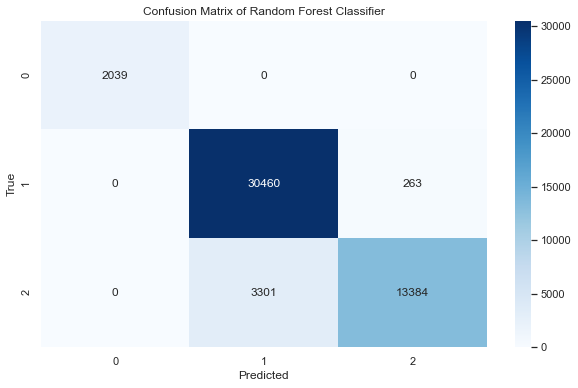

In [98]:
y_pred = clf.predict(X_test)
    
print(classification_report(y_test, y_pred))

# confusion matrix - heat map plot
cm = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion Matrix of Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show();

fig.savefig('randomforest.png', bbox_inches='tight');

In [99]:
clf.feature_importances_

array([9.47972924e-02, 1.20032766e-01, 2.81769170e-02, 7.31044974e-02,
       5.65669922e-02, 6.30504987e-02, 5.72877831e-02, 1.09653680e-02,
       3.17089483e-02, 1.36025141e-01, 4.81475705e-04, 2.75417768e-04,
       1.38549006e-04, 4.02193835e-03, 1.74014736e-03, 2.38657078e-03,
       2.05744624e-03, 3.94174753e-03, 1.07818618e-03, 6.62483259e-03,
       9.65929546e-04, 2.85508394e-03, 1.11652341e-03, 8.75783728e-04,
       2.41079582e-03, 6.95815640e-04, 4.97988732e-03, 7.77089227e-03,
       7.52728161e-04, 5.07539572e-04, 5.96489342e-05, 6.86823321e-03,
       4.01951745e-03, 5.21470351e-04, 1.22501192e-02, 6.50665627e-04,
       2.14851604e-04, 1.99502031e-05, 7.91388391e-05, 1.07862787e-04,
       5.48678814e-04, 2.90376570e-04, 1.92712973e-04, 4.65855744e-04,
       4.33901459e-03, 3.19222919e-03, 7.57378917e-03, 6.33115979e-04,
       1.50444299e-04, 3.49614982e-04, 1.97391607e-06, 3.02503575e-04,
       2.66701901e-04, 3.80157361e-04, 6.15856154e-03, 1.10154394e-03,
      

In [100]:
# Get feature importance from model and map them with feature names
feature_importances = pd.DataFrame(
    clf.feature_importances_
    , index = X_train.columns
    , columns=['importance']
).sort_values(by='importance', ascending=False)

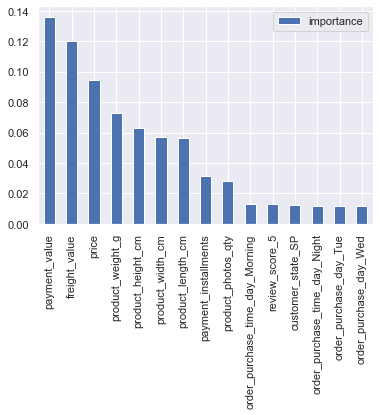

In [103]:
feature_importances.head(15).plot(kind = 'bar')

# Clearly, payment value is the biggest predictor of customer segments. Which is intuitive but not very insightful. In the next sheet, I will explore a different method to understand customers from a non-monetary perspective.